In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap 
import seaborn as sns
from datetime import datetime

from validate_dowscaled_et import prepare_data_for_plotting

In [10]:
ee.Initialize(project="thurgau-irrigation")

In [11]:
def set_negative_to_zero(image):
    return image.where(image.lt(0), 0)

In [12]:
et_collection_2018 = ee.ImageCollection("projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_2018").sort("system:time_start")

et_collection_2018.size().getInfo()

36

In [13]:
ee.Date(et_collection_2018.first().date()).format('YYYY-MM-dd').getInfo()

'2018-01-01'

In [22]:
validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2009_2015").sort("system:time_start")

In [23]:
validation_et_collection.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [8.998612999999999, 47.3800787405]},
 'id': '00000000000000000000',
 'properties': {'date_[YYYYmmdd]': '2009-06-01',
  'evapotranspiration_[mm/d]': 2.4431999999999996,
  'system:time_start': 1243814400000}}

In [26]:
Map = geemap.Map()
point = validation_et_collection.first().geometry()

image = ee.Image(et_collection_2018.toList(36).get(24))

Map.centerObject(point, 12)
Map.addLayer(point, {"color": "red"}, "point")
options = {
    "bands": ["downscaled"],
    "min": 0,
    "max": 300,
    "palette": ["blue", "white", "orange", "red"],
}
Map.addLayer(image, options, "ET")

Map

Map(center=[47.3800787405, 8.998612999999999], controls=(WidgetControl(options=['position', 'transparent_bg'],…

In [46]:
df = geemap.ee_to_df(validation_et_collection)

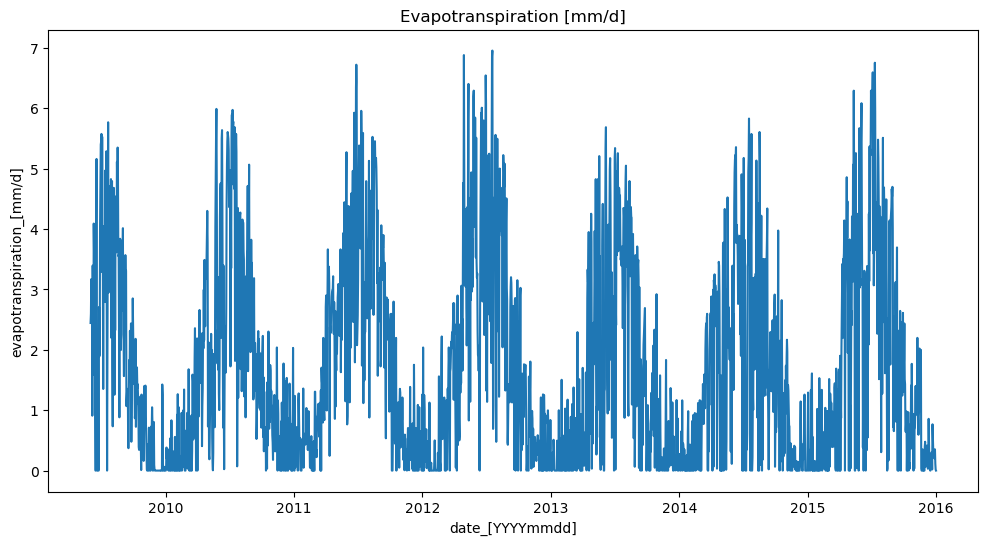

In [47]:
df["date_[YYYYmmdd]"] = pd.to_datetime(df["date_[YYYYmmdd]"])
df = df.set_index("date_[YYYYmmdd]")

# plot evapotranspiration_[mm/d]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df["evapotranspiration_[mm/d]"])
plt.title("Evapotranspiration [mm/d]")
plt.show()

In [28]:
def extract_pixel_values(
    image_collection: ee.ImageCollection, point: ee.Geometry.Point
) -> ee.FeatureCollection:
    """
    Extract the pixel value of the 'downscaled' band for each image in the collection
    at the specified point.

    Args:
        image_collection (ee.ImageCollection): The input image collection.
        point (ee.Geometry.Point): The point at which to extract values.

    Returns:
        ee.FeatureCollection: A feature collection where each feature represents an image
                              and contains the pixel value of the 'downscaled' band at the point.
    """

    def extract_value(image: ee.Image) -> ee.Feature:
        # Select the 'downscaled' band
        downscaled = image.select("downscaled")

        # Get the scale of the 'downscaled' band
        scale = downscaled.projection().nominalScale()

        # Extract the pixel value at the point
        pixel_value = downscaled.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale,
            bestEffort=True,
        ).get("downscaled")

        # Retrieve the image ID (using 'system:index' as an identifier)
        image_id = image.get("system:index")

        # Retrieve the image acquisition time
        time_start = image.get("system:time_start")

        return ee.Feature(
            None,
            {
                "pixel_value": pixel_value,
                "date" : ee.Date(time_start).format("YYYY-MM-dd"),
                "system:time_start": time_start,
            },
        )

    # Map the extraction function over the image collection
    return ee.FeatureCollection(image_collection.map(extract_value))
 

point = validation_et_collection.first().geometry()
raster_collection = extract_pixel_values(et_collection_2018, point)

In [29]:
ee.Date(raster_collection.first().get("system:time_start")).format("YYYY-MM-dd").getInfo()

'2018-01-01'

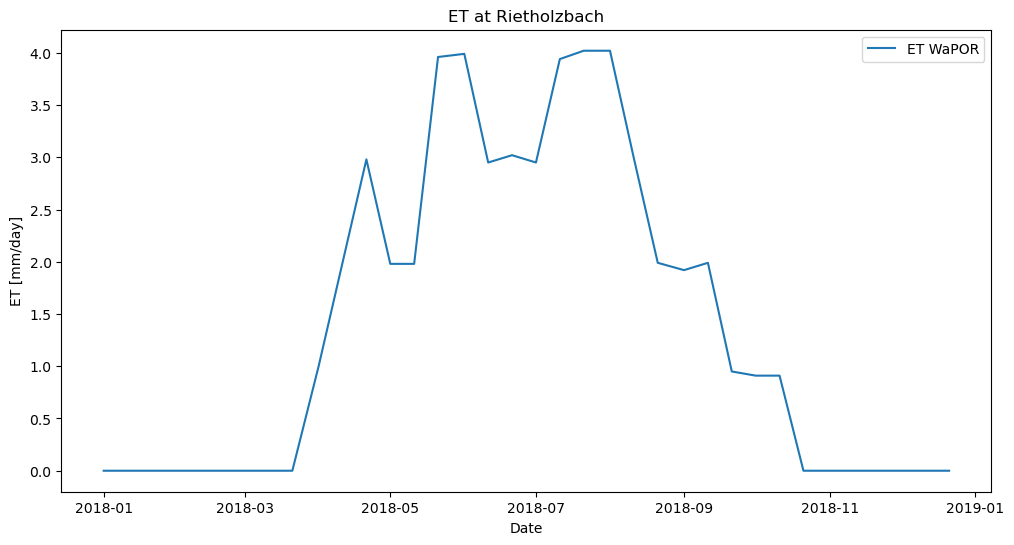

In [33]:
df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
df["ET_[mm/day]"] = df["pixel_value"] / 100


df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["ET_[mm/day]"], label="ET WaPOR")
plt.xlabel("Date")
plt.ylabel("ET [mm/day]")
plt.title("ET at Rietholzbach")
plt.legend()
plt.show()